In [1]:
!nvidia-smi

Thu Jul 27 23:59:10 2023       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 525.60.13    Driver Version: 525.60.13    CUDA Version: 12.0     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  NVIDIA GeForce ...  Off  | 00000000:B1:00.0 Off |                  N/A |
| 22%   25C    P8     6W / 250W |    159MiB / 11264MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
|   1  NVIDIA GeForce ...  Off  | 00000000:B2:00.0 Off |                  N/A |
| 22%   

### Set to default environments

In [2]:
import os
os.chdir("/project/validating_attribution_techniques/abid")

from abid.utils import set_to_our_gpus, enable_web_access, print_cwd, print_gpu_used_torch
enable_web_access()
set_to_our_gpus()

### Imports

In [1]:
from PIL import Image
import torch
from torchvision import transforms, models
from torchvision.models import ResNet18_Weights, ResNet50_Weights, RegNet_Y_16GF_Weights
import numpy as np
import matplotlib.pyplot as plt

from abid.attention_rollout import rollout, grad_rollout, VITAttentionRollout, VITAttentionGradRollout, vit_saliency_map
from abid.viz import visualize_saliency_overlay

from ScoreCAM.cam import CAM, ScoreCAM, GradCAM, GradCAMpp, SmoothGradCAMpp

### Load Deit distilled model

In [2]:
use_cuda = True
device = torch.device("cuda" if use_cuda else "cpu")
vit_distilled_model = torch.hub.load('facebookresearch/deit:main', "deit_tiny_distilled_patch16_224", pretrained=True).to(device)
vit_distilled_model.eval()

classes = open("classes.txt").read().splitlines()

Using cache found in /home/hashimi/.cache/torch/hub/facebookresearch_deit_main


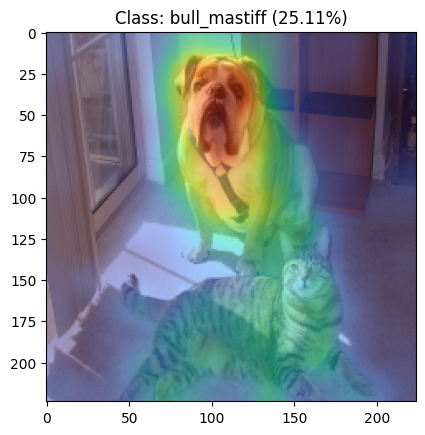

In [3]:
img = Image.open('./examples/input.png')

vit_probs, vit_idx, (vit_cls_mask, vit_distill_mask) = vit_saliency_map(img, vit_distilled_model)
visualize_saliency_overlay(img, vit_cls_mask, vit_probs, vit_idx, classes);

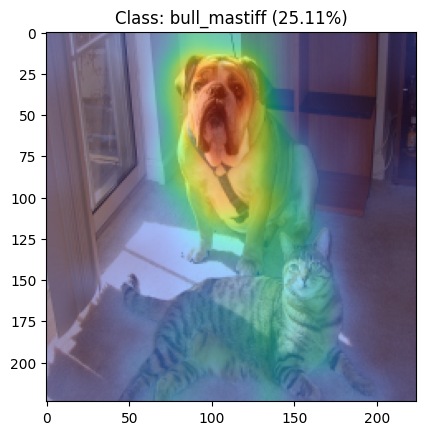

In [4]:
visualize_saliency_overlay(img, vit_distill_mask, vit_probs, vit_idx, classes);

### ResNet Model

In [5]:
resnet_model = models.resnet18(weights=ResNet18_Weights.IMAGENET1K_V1).to(device)
resnet_model.eval();

resnet_transform = transforms.Compose([transforms.Resize((256, 256)),
                                       transforms.ToTensor(),
                                       transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])])

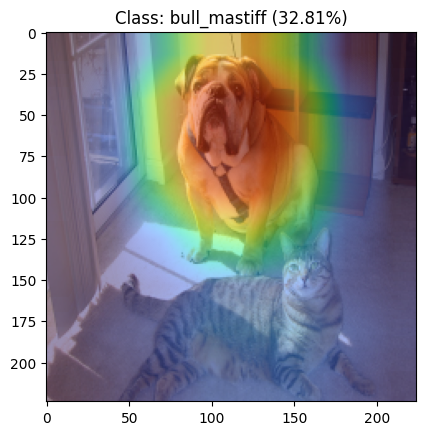

In [6]:
input_tensor = resnet_transform(img).unsqueeze(0).to(device)

target_layer = resnet_model.layer4[1].conv2
wrapped_model = ScoreCAM(resnet_model, target_layer)
resnet_mask, resnet_idx, resnet_probs = wrapped_model(input_tensor)
# plt.imshow(cam.squeeze().numpy())
visualize_saliency_overlay(img, resnet_mask.squeeze().numpy(), resnet_probs, resnet_idx, classes);

### Compare Saliency

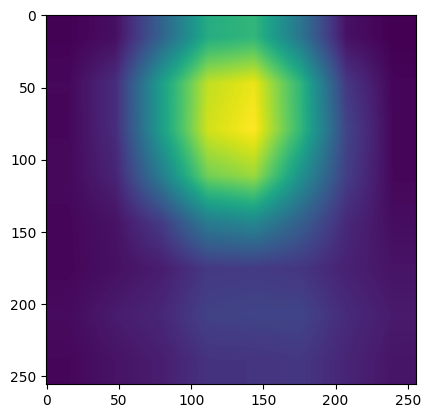

In [7]:
plt.imshow(resnet_mask.squeeze().numpy())

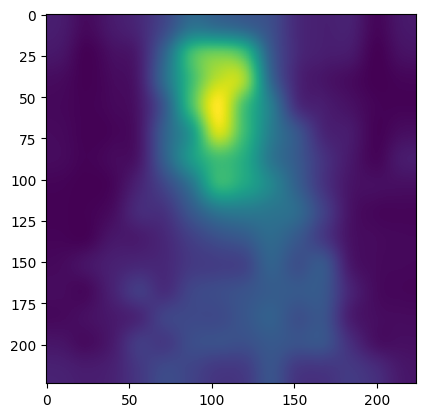

In [8]:
heatmap = Image.fromarray(vit_cls_mask)
vit_cls_mask = np.array(heatmap.resize((np.array(img).shape[0], np.array(img).shape[1])))
plt.imshow(vit_cls_mask)

heatmap = Image.fromarray(vit_distill_mask)
vit_distill_mask = np.array(heatmap.resize((np.array(img).shape[0], np.array(img).shape[1])))
plt.imshow(vit_distill_mask)

In [9]:
from abid.metrics import SIM, CC, NSS, AUC_Judd, AUC_Borji, wasserstein_distance, calculate_metrics

In [12]:
print(f"{SIM(resnet_mask.squeeze().numpy(), vit_cls_mask) = }")
print(f"{CC(resnet_mask.squeeze().numpy(), vit_cls_mask) = }")
print(f"{NSS(resnet_mask.squeeze().numpy(), vit_cls_mask) = }")
print(f"{AUC_Borji(resnet_mask.squeeze().numpy(), vit_cls_mask) = }")
print(f"{AUC_Judd(resnet_mask.squeeze().numpy(), vit_cls_mask) = }\n")
# print(wasserstein_distance(resnet_mask.squeeze().numpy(), vit_cls_mask))

print(f"{SIM(resnet_mask.squeeze().numpy(), vit_distill_mask) = }")
print(f"{CC(resnet_mask.squeeze().numpy(), vit_distill_mask) = }")
print(f"{NSS(resnet_mask.squeeze().numpy(), vit_distill_mask) = }")
print(f"{AUC_Borji(resnet_mask.squeeze().numpy(), vit_distill_mask) = }")
print(f"{AUC_Judd(resnet_mask.squeeze().numpy(), vit_distill_mask) = }")

SIM(resnet_mask.squeeze().numpy(), vit_cls_mask) = 0.7760384
CC(resnet_mask.squeeze().numpy(), vit_cls_mask) = 0.8289131460658911
NSS(resnet_mask.squeeze().numpy(), vit_cls_mask) = 2.1860611
AUC_Borji(resnet_mask.squeeze().numpy(), vit_cls_mask) = 0.9414460460447485
AUC_Judd(resnet_mask.squeeze().numpy(), vit_cls_mask) = 0.9857379171399167

SIM(resnet_mask.squeeze().numpy(), vit_distill_mask) = 0.79408735
CC(resnet_mask.squeeze().numpy(), vit_distill_mask) = 0.8590206208268569
NSS(resnet_mask.squeeze().numpy(), vit_distill_mask) = 2.1821048
AUC_Borji(resnet_mask.squeeze().numpy(), vit_distill_mask) = 0.9408111077258974
AUC_Judd(resnet_mask.squeeze().numpy(), vit_distill_mask) = 0.9860847147231026


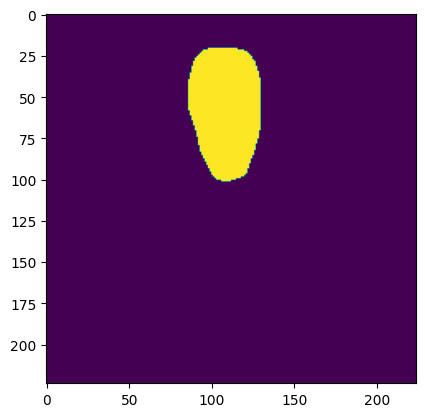

In [10]:
tmp = Image.fromarray(resnet_mask.squeeze().numpy()).resize((224, 224))
tmp_np = np.array(tmp)
plt.imshow((vit_cls_mask * tmp_np) > 0.5)

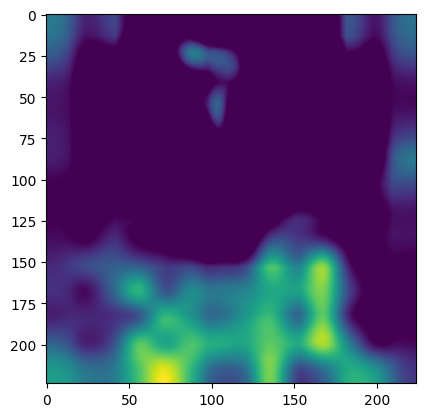

In [11]:
plt.imshow((vit_cls_mask - tmp_np).clip(0, 1))

- We multiply the saliency of the resnet and vit and then see how much of the result resides inside the polygon. Maybe divide the polygon
- Comparison with the polygonal saliency map.
- Subtract the vit saliency from the resnet one to see which parts of the saliency is in resnet that is not in the vit
  - We can use this to then check which parts of this residue sits outside the polygon and then use adversarial noise on those parts to see if the model changes its accuracy or not, and by how much.

In [12]:
from abid.segment_saliency import generate_segmentation_mask, pixels_to_polygon, polygon_to_pixels, generate_saliency_from_polygon, plot_polygon

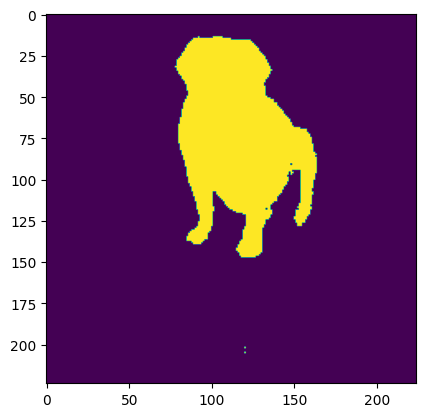

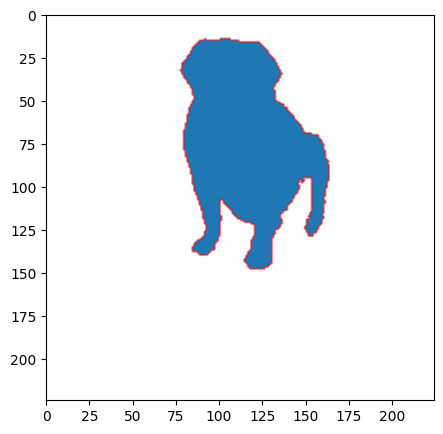

In [13]:
masks, scores, logits = generate_segmentation_mask(image=np.array(img), coords=np.array([[100, 50]]))
plt.imshow(masks[0])

mask_poly = pixels_to_polygon(masks[0])
plot_polygon(mask_poly, 224, 224)

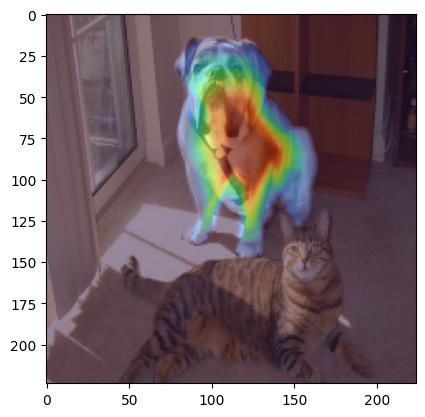

In [14]:
img_gen_saliency = generate_saliency_from_polygon(mask_poly, img.height, img.width)
visualize_saliency_overlay(np.array(img), img_gen_saliency);

In [15]:
salient_gen_pixels = polygon_to_pixels(mask_poly, img.height, img.width)

In [16]:
resnet_salinecy_tmp = Image.fromarray(resnet_mask.squeeze().numpy()).resize((224, 224))
resnet_mask_resized_np = np.array(resnet_salinecy_tmp)

### Metrics against the generated saliency map

In [52]:
print(f"{SIM(resnet_mask_resized_np, vit_cls_mask) = }")
print(f"{CC(resnet_mask_resized_np, vit_cls_mask) = }")
print(f"{NSS(resnet_mask_resized_np, vit_cls_mask) = }")
print(f"{AUC_Borji(resnet_mask_resized_np, vit_cls_mask) = }")
print(f"{AUC_Judd(resnet_mask_resized_np, vit_cls_mask) = }\n")
# print(wasserstein_distance(resnet_mask.squeeze().numpy(), vit_cls_mask))

SIM(resnet_mask_resized_np, vit_cls_mask) = 0.77604043
CC(resnet_mask_resized_np, vit_cls_mask) = 0.8289133695573981
NSS(resnet_mask_resized_np, vit_cls_mask) = 2.186071
AUC_Borji(resnet_mask_resized_np, vit_cls_mask) = 0.9411998441349536
AUC_Judd(resnet_mask_resized_np, vit_cls_mask) = 0.9857371495480695



### ResNet Salient Value Isolation

- First see the saliency of the resnet and then check how much of the saliency has been "transferred" to the vit
  - The way we can check this is to calculate how much of the saliency values for resnet lies inside the polygon of the segmented data, and how  much is outside the polygon.
  - Then you compare this to the saliency that we got from the vit and see how close they really are in terms of their saliency.

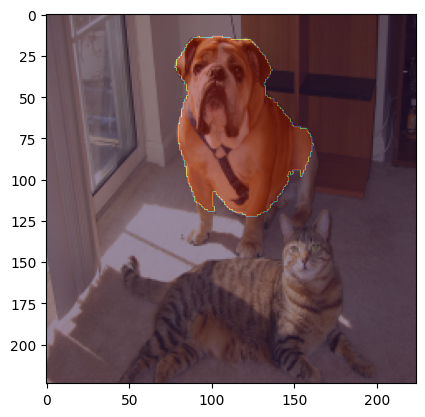

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]], dtype=float32)

In [18]:
visualize_saliency_overlay(img, salient_gen_pixels * (resnet_mask_resized_np > 0.5))

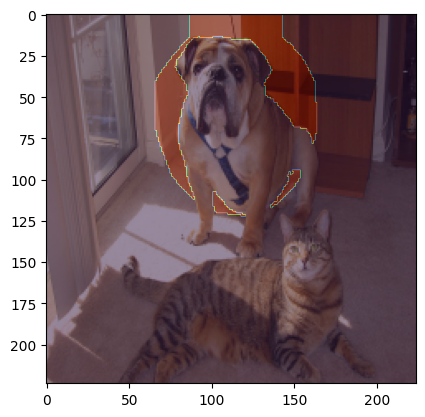

In [19]:
visualize_saliency_overlay(img, np.logical_not(salient_gen_pixels).astype(float) *
                           (resnet_mask_resized_np > 0.5));

### Deit Salient value isolation

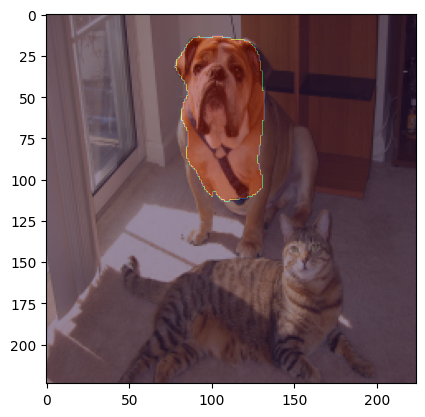

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]], dtype=float32)

In [20]:
visualize_saliency_overlay(img, salient_gen_pixels * (vit_cls_mask > 0.5))

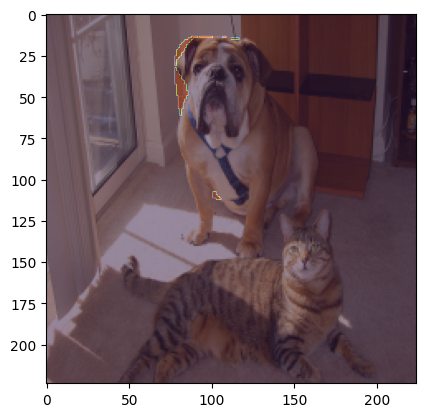

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]], dtype=float32)

In [21]:
visualize_saliency_overlay(img, np.logical_not(salient_gen_pixels).astype(float) *
                           (vit_cls_mask > 0.5))

### In-salient to out-salient ratio

In [217]:
inter_model_saliency = resnet_mask_resized_np * vit_cls_mask

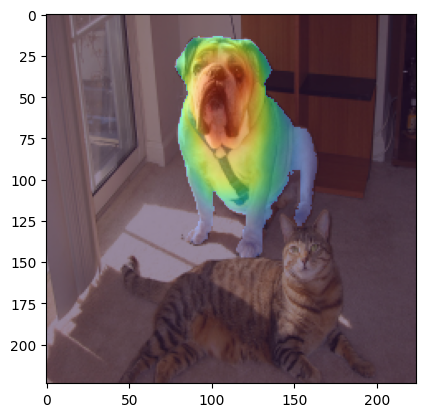

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]], dtype=float32)

In [72]:
visualize_saliency_overlay(img, salient_gen_pixels * (inter_model_saliency))

In [152]:
insalient_inter_model_saliency = (inter_model_saliency *  salient_gen_pixels)
insalient_inter_model_saliency_norm = insalient_inter_model_saliency / insalient_inter_model_saliency.max()
insalient_inter_model_saliency_norm = np.where(insalient_inter_model_saliency_norm >= 0.9, 1, insalient_inter_model_saliency_norm)

resnet_mask_insalient = resnet_mask_resized_np * salient_gen_pixels
resnet_mask_insalient_probs = resnet_mask_insalient / resnet_mask_resized_np.sum()
resnet_mask_insalient_probs.max()

insalient_expected = np.sum(insalient_inter_model_saliency_norm * resnet_mask_insalient_probs)
insalient_expected

0.223259680116773

In [155]:
outsalient_inter_model_saliency = (inter_model_saliency *  np.logical_not(salient_gen_pixels).astype(float))
outsalient_inter_model_saliency_norm = outsalient_inter_model_saliency / outsalient_inter_model_saliency.max()
outsalient_inter_model_saliency_norm = np.where(outsalient_inter_model_saliency_norm >= 0.9, 1, inter_model_saliency_norm)

resnet_mask_outsalient = resnet_mask_resized_np * np.logical_not(salient_gen_pixels).astype(float)
resnet_mask_outsalient_probs = resnet_mask_outsalient / resnet_mask_outsalient.sum()
resnet_mask_outsalient_probs.max()

outsalient_expected = np.sum(outsalient_inter_model_saliency_norm * resnet_mask_outsalient_probs)
outsalient_expected

0.09495868527661426

In [218]:
insalient_outsalient_ratio(resnet_mask, vit_cls_mask, salient_gen_pixels)

0.5564591768991628

In [157]:
insalient_expected / (insalient_expected + outsalient_expected)

0.7015926935605221

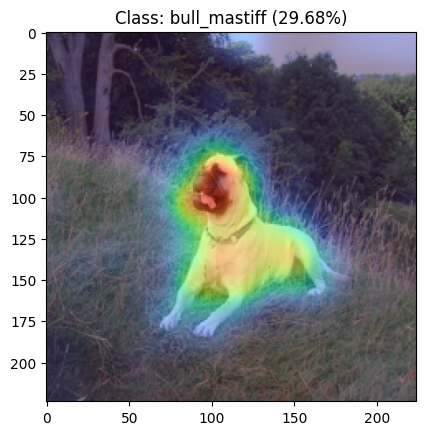

In [224]:
img = Image.open('./examples/dog_chillin.jpg').resize((224, 224))

vit_probs, vit_idx, (vit_cls_mask, vit_distill_mask) = vit_saliency_map(img, vit_distilled_model)
visualize_saliency_overlay(img, vit_cls_mask, vit_probs, vit_idx, classes);

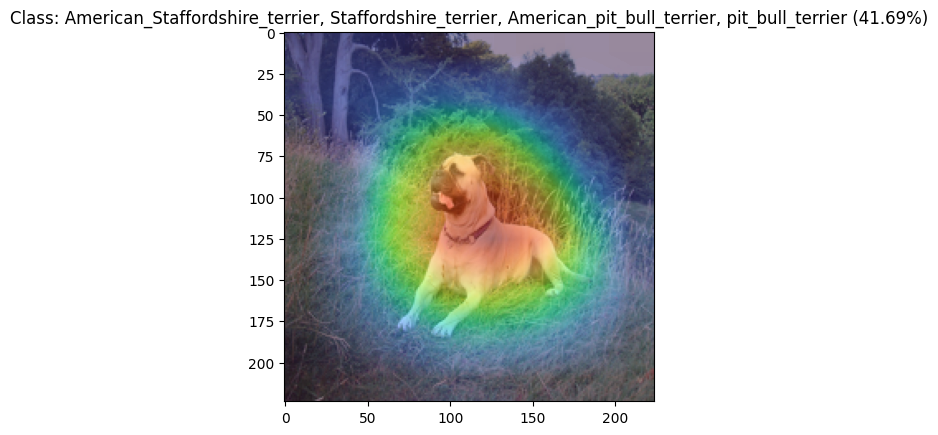

In [225]:
input_tensor = resnet_transform(img).unsqueeze(0).to(device)

target_layer = resnet_model.layer4[1].conv2
wrapped_model = ScoreCAM(resnet_model, target_layer)
resnet_mask, resnet_idx, resnet_probs = wrapped_model(input_tensor)
visualize_saliency_overlay(img, resnet_mask.squeeze().numpy(), resnet_probs, resnet_idx, classes);

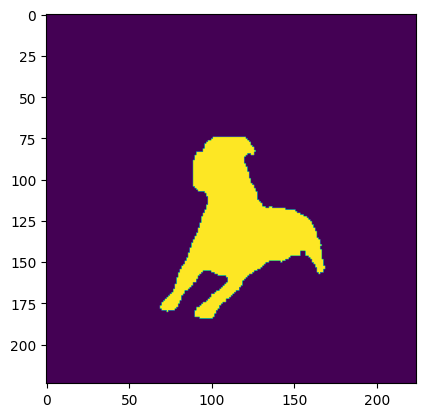

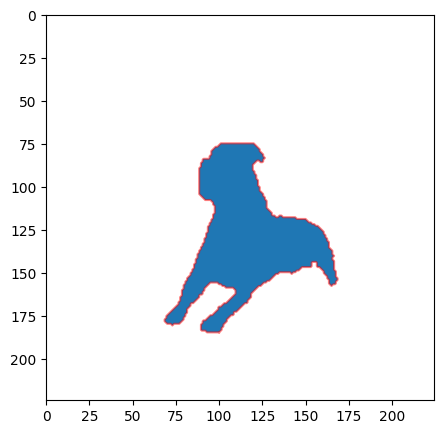

In [226]:
masks, scores, logits = generate_segmentation_mask(image=np.array(img), coords=np.array([[110, 125]]))
plt.imshow(masks[0])

mask_poly = pixels_to_polygon(masks[0])
plot_polygon(mask_poly, 224, 224)

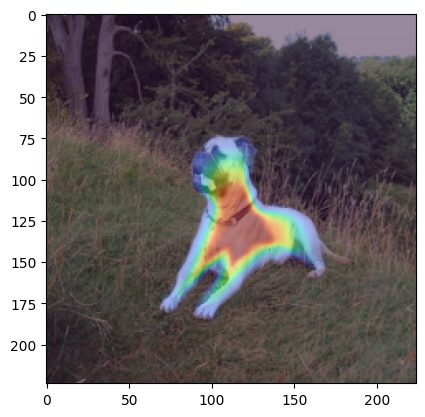

In [227]:
img_gen_saliency = generate_saliency_from_polygon(mask_poly, img.height, img.width)
visualize_saliency_overlay(np.array(img), img_gen_saliency);

In [228]:
salient_gen_pixels = polygon_to_pixels(mask_poly, img.height, img.width)
heatmap = Image.fromarray(vit_cls_mask)
vit_cls_mask = np.array(heatmap.resize((np.array(img).shape[0], np.array(img).shape[1])))

In [243]:
def insalient_outsalient_ratio(resnet_mask, vit_mask, salient_gen_pixels):
    resnet_salinecy_tmp = Image.fromarray(resnet_mask.squeeze().numpy()).resize(vit_mask.shape)
    resnet_mask = np.array(resnet_salinecy_tmp)

    inter_model_saliency = resnet_mask * vit_mask
    plt.imshow(inter_model_saliency)

    insalient_inter_model_saliency = (inter_model_saliency * salient_gen_pixels)
    insalient_inter_model_saliency_norm = insalient_inter_model_saliency / insalient_inter_model_saliency.max()
    insalient_inter_model_saliency_norm = np.where(insalient_inter_model_saliency_norm >= 0.9, 1, insalient_inter_model_saliency_norm)

    resnet_mask_insalient = resnet_mask * salient_gen_pixels
    resnet_mask_insalient_probs = resnet_mask_insalient / resnet_mask_insalient.sum()

    insalient_expected = np.sum(insalient_inter_model_saliency_norm * resnet_mask_insalient_probs)

    outsalient_inter_model_saliency = (inter_model_saliency * np.logical_not(salient_gen_pixels).astype(float))
    outsalient_inter_model_saliency_norm = outsalient_inter_model_saliency / outsalient_inter_model_saliency.max()
    outsalient_inter_model_saliency_norm = np.where(outsalient_inter_model_saliency_norm >= 0.9, 1, outsalient_inter_model_saliency_norm)

    resnet_mask_outsalient = resnet_mask * np.logical_not(salient_gen_pixels).astype(float)
    resnet_mask_outsalient_probs = resnet_mask_outsalient / resnet_mask_outsalient.sum()

    outsalient_expected = np.sum(outsalient_inter_model_saliency_norm * resnet_mask_outsalient_probs)

    return insalient_expected / (insalient_expected + outsalient_expected)

0.8279805463935163

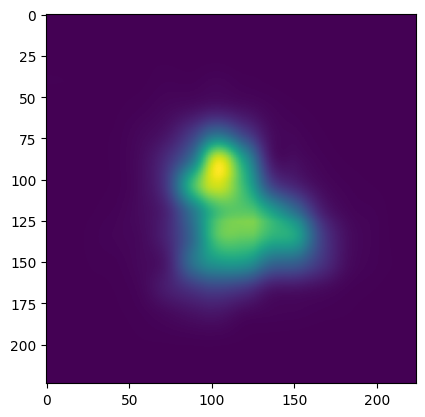

In [244]:
insalient_outsalient_ratio(resnet_mask, vit_cls_mask, salient_gen_pixels)

In [209]:
insalient_expected / (insalient_expected + outsalient_expected)

0.7024847502568723

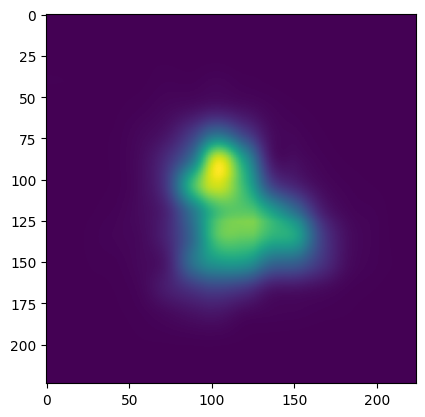

In [237]:
plt.imshow(np.array(Image.fromarray(resnet_mask.squeeze().numpy()).resize(vit_cls_mask.shape)) * vit_cls_mask)

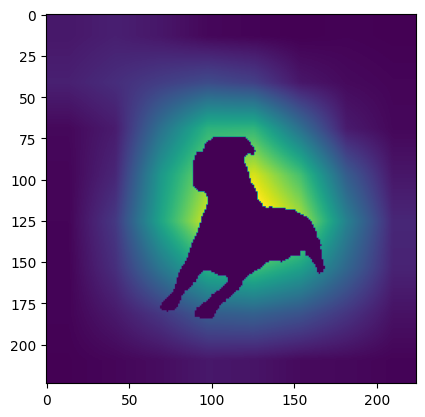

In [242]:
plt.imshow(np.array(Image.fromarray(resnet_mask.squeeze().numpy()).resize(vit_cls_mask.shape))
            * np.logical_not(salient_gen_pixels).astype(float))

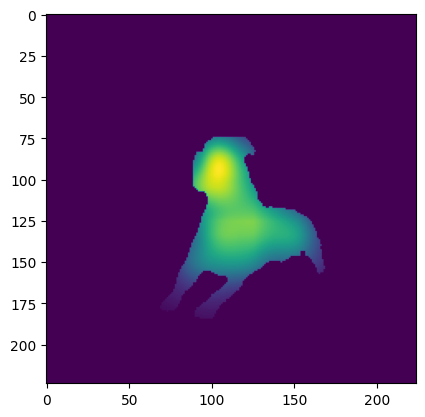

In [239]:
plt.imshow(np.array(Image.fromarray(resnet_mask.squeeze().numpy()).resize(vit_cls_mask.shape)) *
                    vit_cls_mask * salient_gen_pixels)

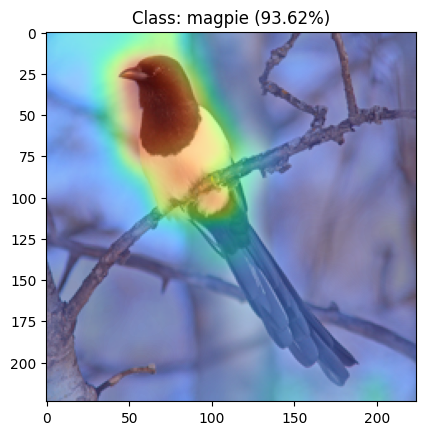

In [246]:
img = Image.open('./examples/bird_menace.jpg').resize((224, 224))

vit_probs, vit_idx, (vit_cls_mask, vit_distill_mask) = vit_saliency_map(img, vit_distilled_model)
visualize_saliency_overlay(img, vit_cls_mask, vit_probs, vit_idx, classes);

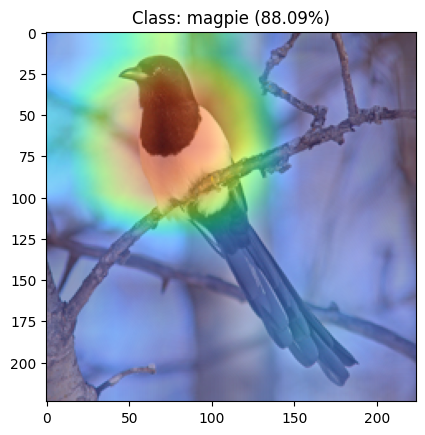

In [248]:
input_tensor = resnet_transform(img).unsqueeze(0).to(device)

target_layer = resnet_model.layer4[1].conv2
wrapped_model = ScoreCAM(resnet_model, target_layer)
resnet_mask, resnet_idx, resnet_probs = wrapped_model(input_tensor)
visualize_saliency_overlay(img, resnet_mask.squeeze().numpy(), resnet_probs, resnet_idx, classes);

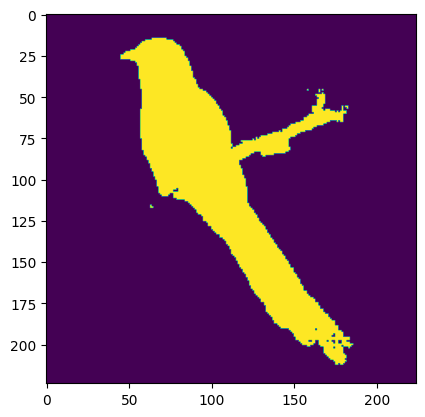

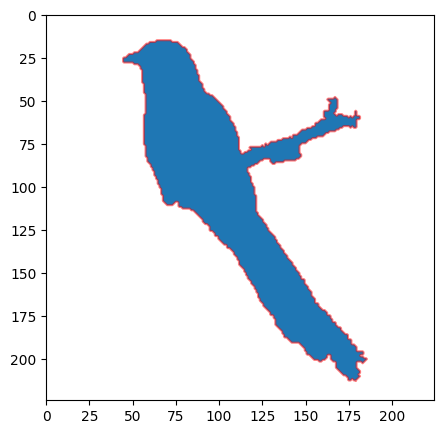

In [249]:
masks, scores, logits = generate_segmentation_mask(image=np.array(img), coords=np.array([[75, 75]]))
plt.imshow(masks[0])

mask_poly = pixels_to_polygon(masks[0])
plot_polygon(mask_poly, 224, 224)

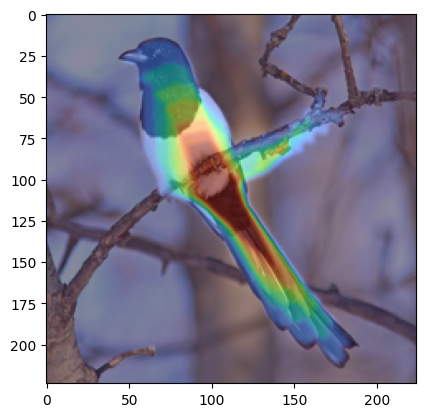

In [250]:
img_gen_saliency = generate_saliency_from_polygon(mask_poly, img.height, img.width)
visualize_saliency_overlay(np.array(img), img_gen_saliency);

In [251]:
salient_gen_pixels = polygon_to_pixels(mask_poly, img.height, img.width)
heatmap = Image.fromarray(vit_cls_mask)
vit_cls_mask = np.array(heatmap.resize((np.array(img).shape[0], np.array(img).shape[1])))

0.7541358428573469

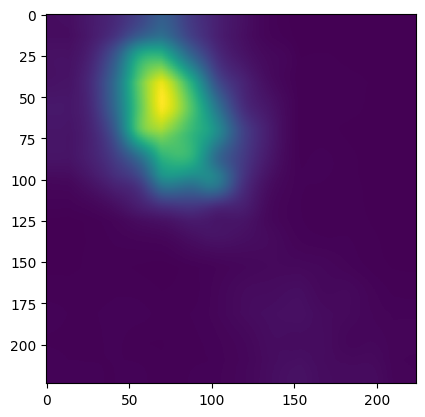

In [252]:
insalient_outsalient_ratio(resnet_mask, vit_cls_mask, salient_gen_pixels)

Things to improve on:
- The segmentation should be automated. See if the segment anything model can work, if not we have to change it
- Polygonal margins that defines the border of the insaliency should either become fuzzy, or we can also scale it all little, in order to take into account the fact that cam is scaled up and also the that due to the convolution operation, some saliencies seep outside borders.
- Occlusion based input perturbation and tracking the change in accuracy, and the standard deviation of the accuracy.
- Someone has got to do the documentation of the modules ☹️

### Testing the new imports from the commons directory

In [17]:
import sys
sys.path.append("..")

In [18]:
from commons.api.metric.ior import insalient_outsalient_ratio

In [19]:
sys.path.append("abid")

In [20]:
insalient_outsalient_ratio

<function commons.api.metric.ior.insalient_outsalient_ratio(reference, comparative, object_mask)>

In [21]:
insalient_outsalient_ratio(resnet_mask_resized_np, vit_cls_mask, salient_gen_pixels)

0.7512492932314999